In [278]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

COST_ADDING_NODE = 1
COST_REMOVING_NODE = 1
COST_ADDING_EDGE = 1
COST_REMOVING_EDGE = 1
COST_EDIT_EDGE = 1

In [279]:
G1 = nx.Graph([(1, 2), (2, 3), (3, 4), (4, 1), (3, 1)])
# G = nx.Graph([(1, 2), (2, 3), (1, 3)])
# G.add_nodes_from([4])
G = nx.Graph([(1, 2), (2, 3), (3, 1)])
# G1.add_nodes_from([1,2,3])

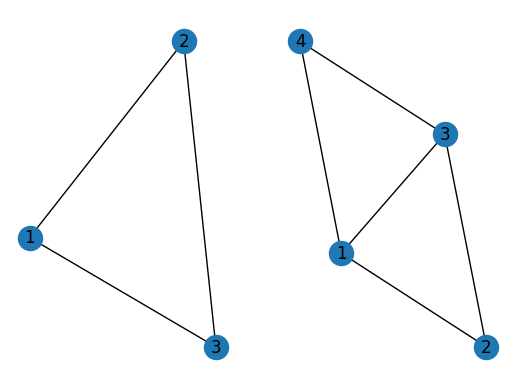

In [280]:
def plot_graphs(*args):
    for G in args:
        units = args.index(G) + 1
        dizaines = len(args)
        num = 100 + dizaines * 10 + units
        plt.subplot(num)
        nx.draw(G, with_labels='True')
    plt.show()


plot_graphs(G, G1)

In [281]:
import itertools


def generate_permutation_matrices(size):
    identity_matrix = np.eye(size, dtype=int)
    permutation_matrices = []

    # Generate all permutations of rows of the identity matrix
    row_permutations = itertools.permutations(range(size))

    for permuted_indices in row_permutations:
        # Create a permutation matrix using the permuted row indices
        permutation_matrix = identity_matrix[list(permuted_indices)]
        permutation_matrices.append(permutation_matrix)

    return permutation_matrices


""" Takes two matrices and returns True if they are equal up to permutation of rows and columns.
The matrices are assumed to be square and of same shape"""


def equal_up_to_permutation(matrix1, matrix2):
    for i in generate_permutation_matrices(matrix1.shape[0]):
        if np.array_equal(np.matmul(i, matrix1), np.matmul(matrix2, i)):
            return True
    return False


def is_isomorphic(a, b):
    res = False
    if sorted(a.degree()) == sorted(b.degree()):
        adjacencies_a = nx.to_numpy_array(a)
        adjacencies_b = nx.to_numpy_array(b)
        if adjacencies_a.shape == adjacencies_b.shape and adjacencies_a.shape[0] == adjacencies_a.shape[
            1]:  # matrice carrée
            if equal_up_to_permutation(adjacencies_a, adjacencies_b):
                res = True
    return res

In [282]:
"""
Algorithme pour calculer de facon naive la distance entre deux algorithmes, en supprimant et récréant toutes les connexions

Complexité en O(1)
"""


def compute_naive_distance(a, b):
    diff_node = a.number_of_nodes() - b.number_of_nodes()
    cost = (a.number_of_edges() * COST_REMOVING_EDGE +
            b.number_of_edges() * COST_ADDING_EDGE)
    if diff_node > 0:
        cost_nodes = diff_node * COST_REMOVING_NODE
    else:
        cost_nodes = -(diff_node * COST_ADDING_NODE)
    return cost + cost_nodes, cost_nodes


"""
Vérifie si une connexion a une un point commun avec la liste fournie
"""


def no_commun_point(edge, points_edges):
    for i in list(edge):
        if i in points_edges:
            return False
    return True


"""
Construit un dictionnaire qui associe les connexions a éditer avec les connexions possibles dans le graph objectif
"""


def generate_edges_to_edit(start_edges, edges_to_keep, edges_to_remove, edges_goal, ):
    edges_to_edit = [i for i in start_edges if i not in edges_to_keep and i not in edges_to_remove]
    edges_to_edit_with_options = {}
    for i in edges_to_edit:
        options = []
        for j in edges_goal:
            if j not in edges_to_keep and (j[0] == i[0] or j[1] == i[
                1]):  # On vérifie que la connexion ne soit pas déja dans les connexions existantes
                # et qu'elle au moins un point en commun avec les points
                options.append(j)
        if options:
            edges_to_edit_with_options[i] = options
    return edges_to_edit_with_options


def edit_edge(tmp, edge, int):
    tmp.remove_edge(edge)
    new_edge = (list(edge)[0], int)
    tmp.add_edge(new_edge)


def compute_path(b, gsuper, max_distance, start):
    try:
        plot_graphs(gsuper)
        return nx.single_source_dijkstra(gsuper, start, b, cutoff=max_distance)[0]
    except nx.NetworkXNoPath:
        print('No path found')
        return max_distance


def add_to_supergraph(graph, gsuper, tmp, goal, weight):
    is_finished = is_isomorphic(tmp, goal)
    if is_finished:
        gsuper.add_edge(graph, goal, weight=weight)
    else:
        gsuper.add_edge(graph, tmp, weight=weight)
    return is_finished


def compute_distance(a, b):
    if is_isomorphic(a, b):
        return 0
    else:
        max_distance, add_nodes_distances = compute_naive_distance(a, b)
        gsuper = nx.Graph()
        start = a.copy()
        i = 0
        list_nodes = [start]
        nodes_b = list(b.nodes())
        edges_b = list(b.edges())
        nb_nodes_b = len(nodes_b)
        nb_edges_b = len(edges_b)
        while i < max_distance:  # Tant que le cout des options dans le graph est inferieur au cout naif
            new_list_nodes = []
            plot_graphs(*list_nodes)
            for graph in list_nodes:
                tmp = graph.copy()

                if graph.number_of_nodes() < nb_nodes_b:  #S'il manque des nodes, on en ajoute
                    tmp.add_node(graph.number_of_nodes() + 1)
                    if add_to_supergraph(graph, gsuper, tmp, b, COST_ADDING_NODE):
                        return compute_path(b, gsuper, max_distance, start)
                    new_list_nodes.append(tmp)
                elif graph.number_of_nodes() > nb_nodes_b:  # S'il y a des nodes en trop
                    for i in graph.nodes[:nb_nodes_b]:
                        tmp = graph.copy()
                        if not any(graph.neighbors(i)):  #on les supprime si elles n'ont pas de connexions
                            tmp.remove_node(i)
                            print("Test")
                            if add_to_supergraph(graph, gsuper, tmp, b, COST_REMOVING_NODE):
                                return compute_path(b, gsuper, max_distance, start)
                            new_list_nodes.append(tmp)

                # Si les nodes correspondent, il faut modifier les edges
                edges_to_keep = [i for i in graph.edges if i in edges_b]
                interesting_points = set(np.array([i for i in graph.edges if i in edges_b]).ravel())
                edges_to_remove = [i for i in graph.edges if no_commun_point(i, interesting_points)]

                if graph.number_of_edges() > nb_edges_b:  #Il faut supprimer des edges
                    tmp = graph.copy()
                    tmp.remove_edge(*edges_to_remove[0])  # On supprime la premiere connexion inutile
                    if add_to_supergraph(graph, gsuper, tmp, b, COST_REMOVING_EDGE):
                        return compute_path(b, gsuper, max_distance, start)
                    new_list_nodes.append(tmp)
                else:  # 2 cas possibles, edit ou ajouter
                    if graph.number_of_edges() < nb_edges_b:
                        points_allowed = set(np.array(graph.nodes).ravel())
                        edges_to_add = [i for i in edges_b if
                                        i not in graph.edges and (i[0] in points_allowed and i[1] in points_allowed)]
                        print('Adding edge', edges_to_add, points_allowed)
                        for edge in edges_to_add:
                            tmp = graph.copy()
                            print(edge)
                            tmp.add_edge(*edge)
                            if add_to_supergraph(graph, gsuper, tmp, b, COST_ADDING_EDGE):
                                return compute_path(b, gsuper, max_distance, start)
                            new_list_nodes.append(tmp)
                    edges_to_edit = generate_edges_to_edit(graph.edges, edges_to_keep, edges_to_remove, edges_b)
                    for edge, options in edges_to_edit.items():
                        print('edit options')
                        for option in options:
                            tmp = graph.copy()
                            edit_edge(tmp, edge, option)
                            if add_to_supergraph(graph, gsuper, tmp, b, COST_EDIT_EDGE):
                                return compute_path(b, gsuper, max_distance, start)
                            new_list_nodes.append(tmp)
            list_nodes = new_list_nodes
            i += min(COST_ADDING_NODE, COST_REMOVING_NODE, COST_REMOVING_EDGE, COST_ADDING_EDGE, COST_EDIT_EDGE)
        return compute_path(b, gsuper, max_distance, start)

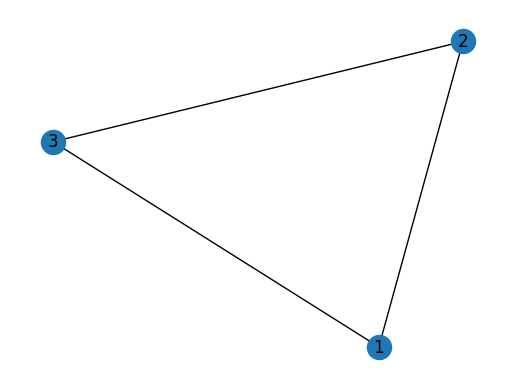

Adding edge [] {1, 2, 3}


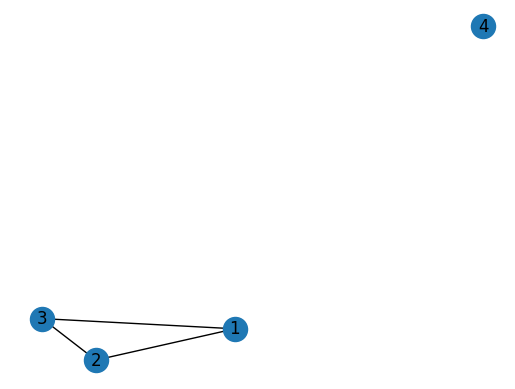

Adding edge [(1, 4), (3, 4)] {1, 2, 3, 4}
(1, 4)
(3, 4)


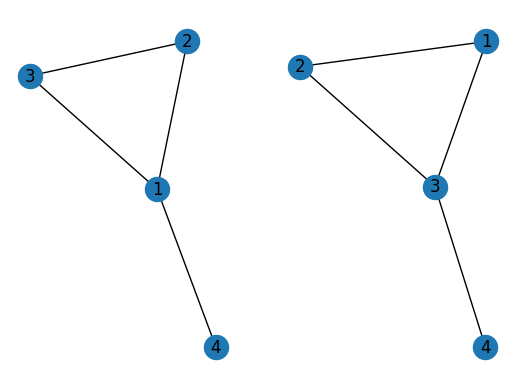

Adding edge [(3, 4)] {1, 2, 3, 4}
(3, 4)


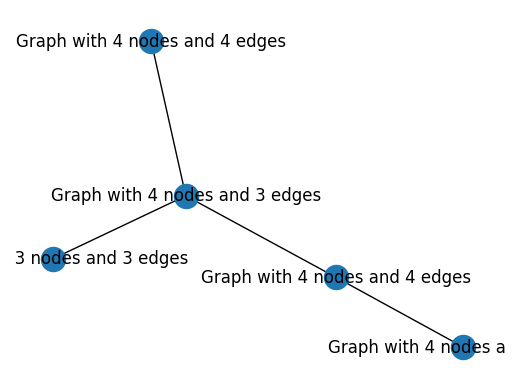

3

In [283]:
compute_distance(G, G1)

In [284]:
set(np.array(G.edges).ravel())

{1, 2, 3}

In [285]:
l = [(1, 4), (3, 4)]
e = set(np.array(G.edges).ravel())
print(l, e)
for i in l:
    if i[0] in e and i[1] in e:
        print("test")

[(1, 4), (3, 4)] {1, 2, 3}
